In [1]:
%matplotlib inline
import numpy as np

In [2]:
! pip install pydicom==1.2.0

## Base of tongue


# Data exploratory:


This example illustrates how to open a DICOM file, print some dataset
information, and show it using matplotlib.


In [6]:
%matplotlib inline

import numpy as np
import pydicom
import os
import matplotlib.pyplot as plt
from glob import glob
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.tools import FigureFactory as FF
from plotly.graph_objs import *
init_notebook_mode(connected=True)

In [7]:
data_path = "C:/Users/lykha/OneDrive/Documents/Medical-imaging-Research/Data/HNSCC/HNSCC-01-0217/12-16-2012-002-95635/2.000000-ORALNASOPHARYNX-83562"
output_path = working_path = "C:/Users/lykha/OneDrive/Documents/Medical-imaging-Research/Sample_data/"
g = glob(data_path + '/*.dcm')

# Print out the first 5 file names to verify we're in the right folder.
print ("Total of %d DICOM images./nFirst 5 filenames:" % len(g))
print('/n'.join(g[:5]))

Total of 59 DICOM images./nFirst 5 filenames:
C:/Users/lykha/OneDrive/Documents/Medical-imaging-Research/Data/HNSCC/HNSCC-01-0217/12-16-2012-002-95635/2.000000-ORALNASOPHARYNX-83562\1-001.dcm/nC:/Users/lykha/OneDrive/Documents/Medical-imaging-Research/Data/HNSCC/HNSCC-01-0217/12-16-2012-002-95635/2.000000-ORALNASOPHARYNX-83562\1-002.dcm/nC:/Users/lykha/OneDrive/Documents/Medical-imaging-Research/Data/HNSCC/HNSCC-01-0217/12-16-2012-002-95635/2.000000-ORALNASOPHARYNX-83562\1-003.dcm/nC:/Users/lykha/OneDrive/Documents/Medical-imaging-Research/Data/HNSCC/HNSCC-01-0217/12-16-2012-002-95635/2.000000-ORALNASOPHARYNX-83562\1-004.dcm/nC:/Users/lykha/OneDrive/Documents/Medical-imaging-Research/Data/HNSCC/HNSCC-01-0217/12-16-2012-002-95635/2.000000-ORALNASOPHARYNX-83562\1-005.dcm


In [8]:
#      
# Loop over the image files and store everything into a list.
# 

def load_scan(path):
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)
    print(type(image))
    print(image.shape)
    # Set outside-of-scan pixels to 1
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

id=0
patient = load_scan(data_path)
imgs = get_pixels_hu(patient)

<class 'numpy.ndarray'>
(59, 512, 512)


In [9]:
np.save(output_path + "fullimages_%d.npy" % (id), imgs)

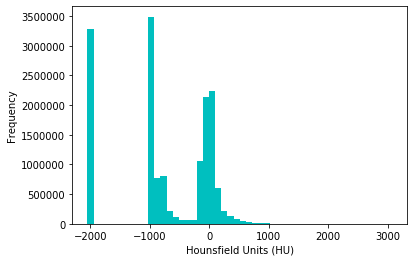

In [10]:
file_used=output_path+"fullimages_%d.npy" % id
imgs_to_process = np.load(file_used).astype(np.float64) 

plt.hist(imgs_to_process.flatten(), bins=50, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

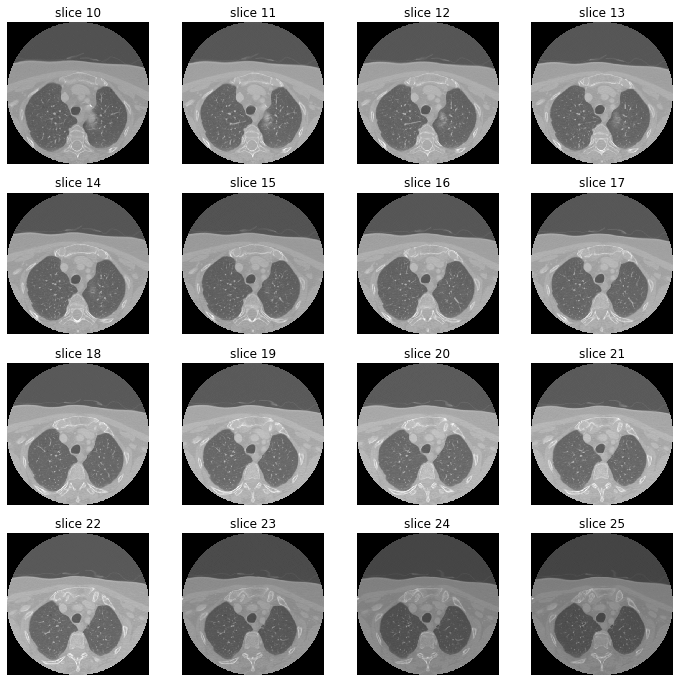

In [11]:
id = 0
imgs_to_process = np.load(output_path+'fullimages_{}.npy'.format(id))

def sample_stack(stack, rows=4, cols=4, start_with=10, show_every=1):
    fig,ax = plt.subplots(rows,cols,figsize=[12,12])
    for i in range(rows*cols):
        ind = start_with + i*show_every
        ax[int(i/rows),int(i % rows)].set_title('slice %d' % ind)
        ax[int(i/rows),int(i % rows)].imshow(stack[ind],cmap='gray')
        ax[int(i/rows),int(i % rows)].axis('off')
    plt.show()

sample_stack(imgs_to_process)

In [12]:
print("Slice Thickness: %f" % patient[0].SliceThickness)
print("Pixel Spacing (row, col): (%f, %f) " % (patient[0].PixelSpacing[0], patient[0].PixelSpacing[1]))

Slice Thickness: 1.000000
Pixel Spacing (row, col): (0.488281, 0.488281) 


## Implementation of the algorithm

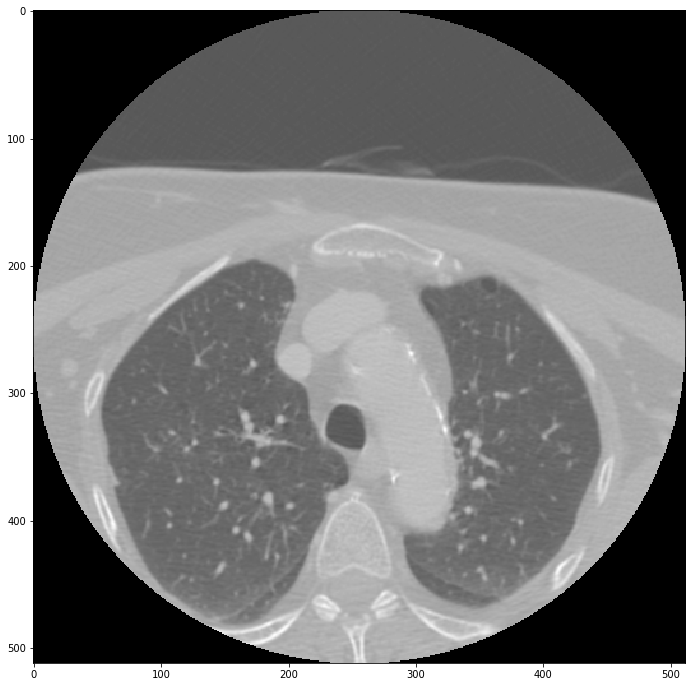

In [19]:
imgs_to_process = np.load(output_path+'fullimages_{}.npy'.format(id))
fig,ax = plt.subplots(1,1,figsize=[12,12])
ax.imshow(imgs_to_process[0], cmap="gray")
plt.show()

In [63]:
from scipy.stats import uniform, norm
img = imgs_to_process[0]
mask = np.ndarray([512, 512],dtype=np.float64)
mask[:] = 0
for i in range(0,512-1):
    for r in range(0, 512-1):    
        voxelsize = np.array([0.488281, 0.488281, 1])
        gradct = (img[r+1,i]-img[r-1, i])/(2*voxelsize)
        a = 50
        Fsd = 1
        Fct = a/(np.linalg.norm(gradct)+a)
        D = Fsd*Fct
        #D = np.linalg.norm(D)
        mask[r, i] = D
    

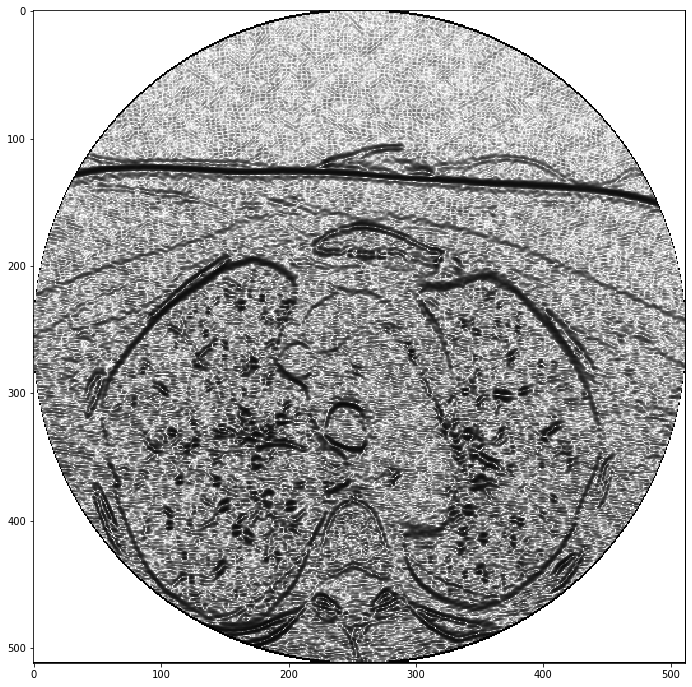

In [64]:
fig,ax = plt.subplots(1,1,figsize=[12,12])
ax.imshow(mask, cmap="gray")
plt.show()

In [ ]:
from scipy.stats import uniform, norm
img = imgs_to_process[0]
#mask = np.ndarray([512, 512],dtype=np.float64)
#mask[:] = 0
Fsd_mat = np.ndarray([512, 512],dtype=np.float64)
Fsd_mat[:] = 0
Fct_mat = np.ndarray([512, 512],dtype=np.float64)
Fct_mat[:] = 0
for i in range(0,512-1):
    for k in range(0, 512-1):
        prand = uniform.rvs(0, 1, size = 1)  
        Fsd_x = norm.cdf(norm.ppf(prand, 0, 1.7))
        Fsd_y = norm.cdf(norm.ppf(prand, 0, 2))
        Fsd_z = norm.cdf(norm.ppf(prand, 0, 2.5))
        Fsd = np.array([Fsd_x, Fsd_y, Fsd_z])
        Fsd = np.linalg.norm(Fsd)
        Fsd_mat[i, k] = Fsd
        
    for r in range(0, 512-1):
        voxelsize = np.array([1, 0.488281, 0.488281])
        gradct = (img[r+1,i]-img[r-1, i])/(2*voxelsize)
        a = 50
        #Fsd = 1
        Fct = a/(np.linalg.norm(gradct)+a)
        #D = Fsd*Fct
        #D = np.linalg.norm(D)
        Fct_mat[r, i] = Fct
        
mask = Fsd_mat*Fct_mat

In [ ]:
fig,ax = plt.subplots(1,1,figsize=[12,12])
ax.imshow(mask, cmap="gray")
plt.show()